In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

In [3]:
get_available_gpus()

['/device:GPU:0']

In [4]:
with np.load("notMNIST.npz") as data :
    Data, Target = data ["images"], data["labels"]
    posClass = 2
    negClass = 9
    dataIndx = (Target==posClass) + (Target==negClass)
    Data = Data[dataIndx]/255.
    Target = Target[dataIndx].reshape(-1, 1)
    Target[Target==posClass] = 1
    Target[Target==negClass] = 0
    np.random.seed(521)
    randIndx = np.arange(len(Data))
    np.random.shuffle(randIndx)
    Data, Target = Data[randIndx], Target[randIndx]
    trainData, trainTarget = Data[:3500], Target[:3500]
    validData, validTarget = Data[3500:3600], Target[3500:3600]
    testData, testTarget = Data[3600:], Target[3600:]

In [5]:
learning_rate = 0.005
n_epochs = 11
batch_size = 500
n_dim = 28*28

In [6]:
def grab_batches(trainData, trainTarget, batch_size):
    batch_indices = np.random.permutation(range(3500)).reshape(-1, batch_size)
    X_batches = trainData.reshape(-1, n_dim)[batch_indices]
    y_batches = trainTarget[batch_indices]
    batches = zip(X_batches, y_batches)
    return batches

In [97]:
X = tf.placeholder(tf.float32,[None,n_dim])
Y = tf.placeholder(tf.float32,[None,1])
W = tf.Variable(tf.ones([n_dim,1]))
weight_decay = tf.placeholder(tf.float32)

In [98]:
y_ = tf.matmul(X, W)

loss = tf.reduce_mean(tf.squared_difference(y_, Y))
regularizer = tf.nn.l2_loss(W)
loss = tf.reduce_mean(loss + weight_decay * regularizer)

prediction = tf.cast(tf.round(tf.sigmoid(y_)), tf.int8)
equality = tf.equal(prediction, tf.cast(Y, tf.int8))
accuracy = tf.reduce_mean(tf.cast(equality, tf.float32))

training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
init = tf.global_variables_initializer()

In [99]:
weight_decays = [0.0, 0.001, 0.1, 1]
valid_accuracies = []
train_accuracies = []
test_accuracies = []

In [100]:
weight_decays = [0.0]
with tf.Session() as sess:
    for wd in weight_decays:
        sess.run(init)
        print("Weight Decay: {} \n".format(wd))
        for epoch in range(1,n_epochs+1):
            batches = grab_batches(trainData, trainTarget, batch_size)
            for X_batch, y_batch in batches:
                sess.run(training_step, feed_dict={X: X_batch, Y: y_batch, weight_decay: wd})
            if epoch % 1 == 0:
                feed_dict ={X: trainData.reshape(-1,n_dim), Y: trainTarget, weight_decay: wd}
                train_loss, train_accuracy = sess.run([loss, accuracy], feed_dict)
                print("Epoch: {}, Loss: {}, Accuracy: {}".format(epoch, train_loss, train_accuracy))
        train_accuracies.append(train_accuracy)
        valid_accuracy = sess.run(accuracy, feed_dict = {X: validData.reshape(-1,n_dim), Y: validTarget})
        valid_accuracies.append(valid_accuracy)
        test_accuracy = sess.run(accuracy, feed_dict = {X: testData.reshape(-1,n_dim), Y: testTarget})
        test_accuracies.append(test_accuracy)

Weight Decay: 0.0 

Epoch: 1, Loss: 240.92306518554688, Accuracy: 0.5271428823471069
Epoch: 2, Loss: 126.56452941894531, Accuracy: 0.5448571443557739
Epoch: 3, Loss: 74.89666748046875, Accuracy: 0.5462856888771057
Epoch: 4, Loss: 48.912418365478516, Accuracy: 0.5337142944335938
Epoch: 5, Loss: 33.4633903503418, Accuracy: 0.5308571457862854
Epoch: 6, Loss: 24.151487350463867, Accuracy: 0.5402857065200806
Epoch: 7, Loss: 18.263916015625, Accuracy: 0.5488571524620056
Epoch: 8, Loss: 14.125530242919922, Accuracy: 0.5608571171760559
Epoch: 9, Loss: 11.208854675292969, Accuracy: 0.5805714130401611
Epoch: 10, Loss: 9.109009742736816, Accuracy: 0.5688571333885193
Epoch: 11, Loss: 7.516256809234619, Accuracy: 0.5854285955429077


In [22]:
valid_accuracies

[0.73, 0.72, 0.67, 0.66]

In [101]:
train_accuracies

[0.5854286]

In [24]:
test_accuracies

[0.7862069, 0.7586207, 0.71034485, 0.7241379]

## Comparison SGD with Normal Equation

In [66]:
def normal_equation():
    X = tf.placeholder(tf.float32,[None,n_dim])
    Y = tf.placeholder(tf.float32,[None,1])
    X_train = tf.convert_to_tensor(trainData.reshape(-1,n_dim), dtype=tf.float32)
    Y_train = tf.convert_to_tensor(trainTarget, dtype=tf.float32)
    W = tf.matmul(tf.matrix_inverse(tf.matmul(tf.transpose(X_train),X_train)), tf.matmul(tf.transpose(X_train), Y_train))
    y_ = tf.matmul(X, W)

    loss = tf.reduce_mean(tf.squared_difference(y_, Y))

    prediction = tf.cast(tf.round(tf.sigmoid(y_)), tf.int8)
    equality = tf.equal(prediction, tf.cast(Y, tf.int8))
    accuracy = tf.reduce_mean(tf.cast(equality, tf.float32))

    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        feed_dict ={X: trainData.reshape(-1,n_dim), Y: trainTarget}
        train_metrics = sess.run([loss, accuracy], feed_dict)
        valid_metrics = sess.run([loss, accuracy], {X: validData.reshape(-1,n_dim), Y: validTarget})
        test_metrics = sess.run([loss, accuracy], {X: testData.reshape(-1,n_dim), Y: testTarget})
        return train_metrics, valid_metrics, test_metrics

In [70]:
normal_equation()

([0.023104576, 0.724], [0.045321163, 0.72], [0.073808014, 0.74482757])

In [77]:
def train():
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(500):
            batches = grab_batches(trainData, trainTarget, 500)
            for X_batch, y_batch in batches:
                sess.run(training_step, feed_dict={X: X_batch, Y: y_batch, weight_decay: 0.0})
        

In [78]:
import timeit
time = timeit.timeit(stmt='normal_equation()', setup='from __main__ import normal_equation', number=10)/10
print(time)

0.27119013060000724


In [79]:
time = timeit.timeit('train()', setup='from __main__ import train', number=10)/10
print(time)

12.465035603899741


## 2.1.3 Comparison with Linear Regression

#### Logistic Regression without Weight Decay

In [7]:
learning_rate = 0.001
n_epochs = 5000
batch_size = 500
n_dim = 28*28

In [20]:
X = tf.placeholder(tf.float32,[None,n_dim])
Y = tf.placeholder(tf.float32,[None,1])
W = tf.Variable(tf.ones([n_dim,1]))

In [ ]:
y_ = tf.matmul(X, W)

loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_, labels=Y))

prediction = tf.cast(tf.round(tf.sigmoid(y_)), tf.int8)
equality = tf.equal(prediction, tf.cast(Y, tf.int8))
accuracy = tf.reduce_mean(tf.cast(equality, tf.float32))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_step = optimizer.minimize(loss)
init = tf.global_variables_initializer()

In [18]:
valid_accuracies = []
train_accuracies = []
test_accuracies = []
train_losses = []

In [19]:
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(1,n_epochs+1):
        batches = grab_batches(trainData, trainTarget, batch_size)
        for X_batch, y_batch in batches:
            sess.run(training_step, feed_dict={X: X_batch, Y: y_batch})
        if epoch % 100 == 0:
            feed_dict ={X: trainData.reshape(-1,n_dim), Y: trainTarget}
            train_loss, train_accuracy = sess.run([loss, accuracy], feed_dict)
            train_accuracies.append(train_accuracy)
            train_losses.append(train_loss)
            print("Epoch: {}, Loss: {}, Accuracy: {}".format(epoch, train_loss, train_accuracy))
    valid_accuracy = sess.run(accuracy, feed_dict = {X: validData.reshape(-1,n_dim), Y: validTarget})
    valid_accuracies.append(valid_accuracy)
    test_accuracy = sess.run(accuracy, feed_dict = {X: testData.reshape(-1,n_dim), Y: testTarget})
    test_accuracies.append(test_accuracy)

Epoch: 100, Loss: 41.176368713378906, Accuracy: 0.501714289188385
Epoch: 200, Loss: 0.07718716561794281, Accuracy: 0.9791428446769714
Epoch: 300, Loss: 0.06196706369519234, Accuracy: 0.982285737991333
Epoch: 400, Loss: 0.05501476302742958, Accuracy: 0.984000027179718
Epoch: 500, Loss: 0.049847282469272614, Accuracy: 0.9851428866386414
Epoch: 600, Loss: 0.04521753638982773, Accuracy: 0.9865714311599731
Epoch: 700, Loss: 0.04090334102511406, Accuracy: 0.9874285459518433
Epoch: 800, Loss: 0.03696061670780182, Accuracy: 0.9885714054107666
Epoch: 900, Loss: 0.033365897834300995, Accuracy: 0.9897142648696899
Epoch: 1000, Loss: 0.030084749683737755, Accuracy: 0.9908571243286133
Epoch: 1100, Loss: 0.026978496462106705, Accuracy: 0.9925714135169983
Epoch: 1200, Loss: 0.02410147525370121, Accuracy: 0.99314284324646
Epoch: 1300, Loss: 0.021439407020807266, Accuracy: 0.9937142729759216
Epoch: 1400, Loss: 0.019040139392018318, Accuracy: 0.994857132434845
Epoch: 1500, Loss: 0.01691270060837269, Accu

In [73]:
print(train_accuracies[-1])
print(valid_accuracies[-1])
print(test_accuracies[-1])

0.9997143
0.99
0.97931033


#### Linear Regression

In [27]:
X = tf.placeholder(tf.float32,[None,n_dim])
Y = tf.placeholder(tf.float32,[None,1])
W = tf.Variable(tf.ones([n_dim,1]))

In [28]:
y_ = tf.matmul(X, W)

loss = tf.reduce_mean(tf.squared_difference(y_, Y))

prediction = tf.cast(tf.round(tf.sigmoid(y_)), tf.int8)
equality = tf.equal(prediction, tf.cast(Y, tf.int8))
accuracy = tf.reduce_mean(tf.cast(equality, tf.float32))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_step = optimizer.minimize(loss)
init = tf.global_variables_initializer()

In [29]:
linear_valid_accuracies = []
linear_train_accuracies = []
linear_test_accuracies = []
linear_train_losses = []

In [30]:
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(1,n_epochs+1):
        batches = grab_batches(trainData, trainTarget, batch_size)
        for X_batch, y_batch in batches:
            sess.run(training_step, feed_dict={X: X_batch, Y: y_batch})
        if epoch % 100 == 0:
            feed_dict ={X: trainData.reshape(-1,n_dim), Y: trainTarget}
            train_loss, train_accuracy = sess.run([loss, accuracy], feed_dict)
            linear_train_accuracies.append(train_accuracy)
            linear_train_losses.append(train_loss)
            print("Epoch: {}, Loss: {}, Accuracy: {}".format(epoch, train_loss, train_accuracy))
    valid_accuracy = sess.run(accuracy, feed_dict = {X: validData.reshape(-1,n_dim), Y: validTarget})
    linear_valid_accuracies.append(valid_accuracy)
    test_accuracy = sess.run(accuracy, feed_dict = {X: testData.reshape(-1,n_dim), Y: testTarget})
    linear_test_accuracies.append(test_accuracy)

Epoch: 100, Loss: 15978.5302734375, Accuracy: 0.501714289188385
Epoch: 200, Loss: 1142.592529296875, Accuracy: 0.501714289188385
Epoch: 300, Loss: 19.21613883972168, Accuracy: 0.501714289188385
Epoch: 400, Loss: 0.12679937481880188, Accuracy: 0.501714289188385
Epoch: 500, Loss: 0.06903783977031708, Accuracy: 0.7365714311599731
Epoch: 600, Loss: 0.059557490050792694, Accuracy: 0.744857132434845
Epoch: 700, Loss: 0.05367717519402504, Accuracy: 0.730571448802948
Epoch: 800, Loss: 0.04996129497885704, Accuracy: 0.7134285569190979
Epoch: 900, Loss: 0.04728240147233009, Accuracy: 0.7071428298950195
Epoch: 1000, Loss: 0.045112788677215576, Accuracy: 0.702571451663971
Epoch: 1100, Loss: 0.04331653192639351, Accuracy: 0.696571409702301
Epoch: 1200, Loss: 0.0418303906917572, Accuracy: 0.694857120513916
Epoch: 1300, Loss: 0.04056999087333679, Accuracy: 0.6934285759925842
Epoch: 1400, Loss: 0.03944757208228111, Accuracy: 0.6945714354515076
Epoch: 1500, Loss: 0.038397181779146194, Accuracy: 0.70057

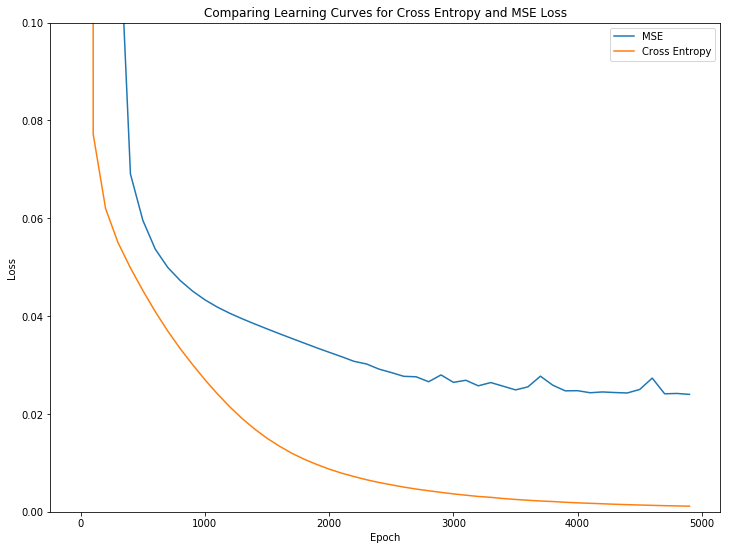

In [39]:
epochs = range(1,5001,100)
plt.figure(figsize=(12,9))
plt.title('Comparing Learning Curves for Cross Entropy and MSE Loss')
plt.plot(epochs, linear_train_losses, label='MSE')
plt.plot(epochs, train_losses, label='Cross Entropy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 0.1)
plt.savefig('figures/xentropy_mse.png', dpi=300, bbox_inches='tight')

Plotting Xentropy and MSE Loss as a function of the prediction between 0 and 1 for dummy target of 0.

In [47]:
probs = np.linspace(0, 1, num=100)
epsilon = 1e-12
target = np.zeros_like(probs)

xentropy = -(target*np.log(probs + epsilon) + (1 - target) * np.log(1 - probs + epsilon))
MSE = (1/2)*np.square(probs - target)

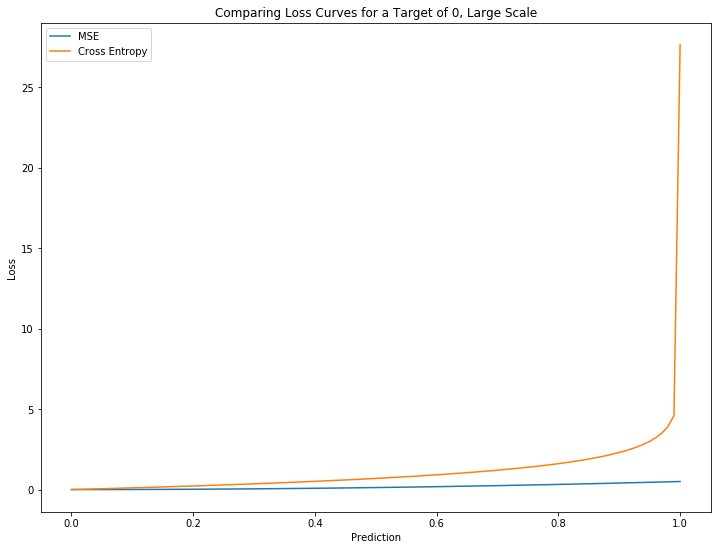

In [51]:
plt.figure(figsize=(12,9))
plt.title('Comparing Loss Curves for a Target of 0, Large Scale')
plt.plot(probs, MSE, label='MSE')
plt.plot(probs, xentropy, label='Cross Entropy')
plt.legend()
plt.xlabel('Prediction')
plt.ylabel('Loss')
plt.savefig('figures/xentropy_mse_losscurve_large.png', dpi=300, bbox_inches='tight')

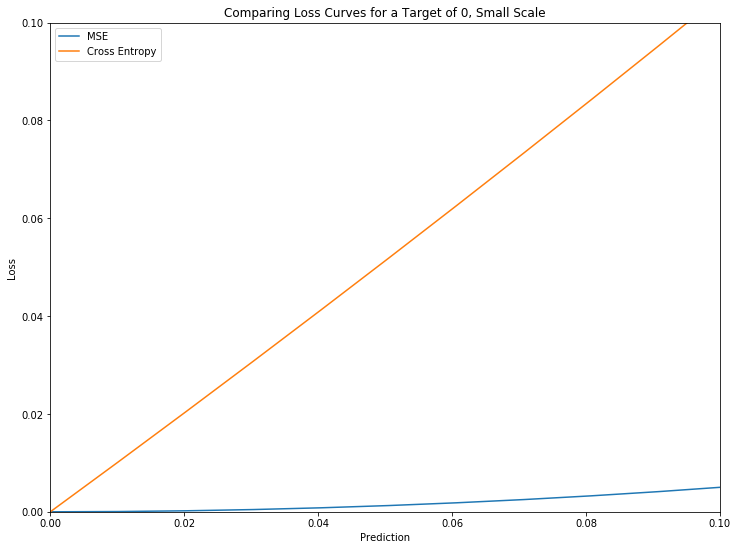

In [55]:
plt.figure(figsize=(12,9))
plt.title('Comparing Loss Curves for a Target of 0, Small Scale')
plt.plot(probs, MSE, label='MSE')
plt.plot(probs, xentropy, label='Cross Entropy')
plt.legend()
plt.xlabel('Prediction')
plt.ylabel('Loss')
plt.ylim(0,0.1)
plt.xlim(0,0.1)
plt.savefig('figures/xentropy_mse_losscurve_small.png', dpi=300, bbox_inches='tight')